In [1]:
obj_dims = (648, 486)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

import os
import json
import scipy.io as sio
from os import path

from src.model import *
from src.utils import *
from src.forward_model import *

import PIL
from PIL import Image

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
model_description = 'model-18.1'

In [5]:
real_data_path = path.join('..', 'data', 'real-data', 'realData.mat')
ground_truth_path = path.join('..', 'data', 'real-data', 'beads_GT.png')

real_res_target_path = '../data/real-data/res_target_z1.tif'

# Paths for saving/loading model weights, predictions
base_path = path.join('..', 'models', model_description)
model_weights_path = path.join(base_path, model_description)
image_path = path.join(base_path, 'prediction-images')

In [6]:
comps_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/comps.npy'
weights_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/weights.npy'

# Load in comps and weights
h = np.load(comps_path)
weights = np.load(weights_path)

psf = tf.squeeze(tf.math.reduce_sum(h*weights, axis=0))
psf = psf / tf.math.reduce_max(psf)
# K = 2000 #this variable can be learned, it has be greater than zero though
K = 1

In [7]:
# UNet multiwiener
registered_psfs_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/9_psfs/psfs_Z1_1_9_registered.npy'

psfs = np.load(registered_psfs_path).transpose([1, 2, 0])
assert psfs.shape == (648, 486, 9)

Ks = np.ones((1, 1, 9))

# Testing

In [8]:
# # UNet for components
# K = 1

# comps = np.squeeze(h, axis=1).transpose(1, 2, 0)[:, :, :6]
# assert comps.shape == (648, 486, 6)

# model = UNet_2d_wiener_components(comps, K)

In [9]:
# Downsample PSFs for downsampled inputs
psfs = tf.image.resize(psfs, [648//2, 486//2])

In [10]:
# model = UNet_2d()
# model = UNet_2d_wiener(psf, K)
model = UNet_2d_multi_wiener(psfs, Ks)



epoch = 'best'
model.load_weights(model_weights_path + '.{}'.format(epoch))

In [11]:
# Read in older mat files with scipy.io
data = sio.loadmat(real_data_path)

In [12]:
beads, res = data['beads'], data['resTarget']
beads = np.array(Image.fromarray(beads).resize(obj_dims, resample=PIL.Image.NEAREST))

# Uncomment if downsampling is applied
beads = np.array(tf.squeeze(tf.image.resize(beads[tf.newaxis, ..., tf.newaxis], [486//2, 648//2]))) # Downsample

beads_input_normed = normalize(beads).T
beads_input = beads_input_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

In [13]:
# res = np.array(Image.fromarray(res).resize(obj_dims, resample=PIL.Image.NEAREST))
# res_input_normed = normalize(res).T
# res_input = res_input_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

In [14]:
# Load in real res target data
real_res = np.array(Image.open(real_res_target_path).resize(obj_dims, resample=PIL.Image.NEAREST))

# Uncomment if downsampling is applied
real_res = np.array(tf.squeeze(tf.image.resize(real_res[tf.newaxis, ..., tf.newaxis], [486//2, 648//2]))) # Downsample

real_res_normed = normalize(real_res).T
real_res_input = real_res_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

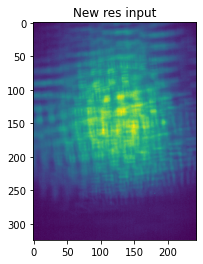

In [15]:
plt.figure()
plt.imshow(real_res_normed)
plt.title('New res input')
plt.show()

In [16]:
pred_beads = model.predict(beads_input).squeeze()

In [17]:
pred_res_real = model.predict(real_res_input).squeeze()

In [18]:
beads_gt_im = Image.open(ground_truth_path)
beads_gt = np.array(beads_gt_im).T
# Normalize beads from 0 to 1
beads_gt = normalize(beads_gt)

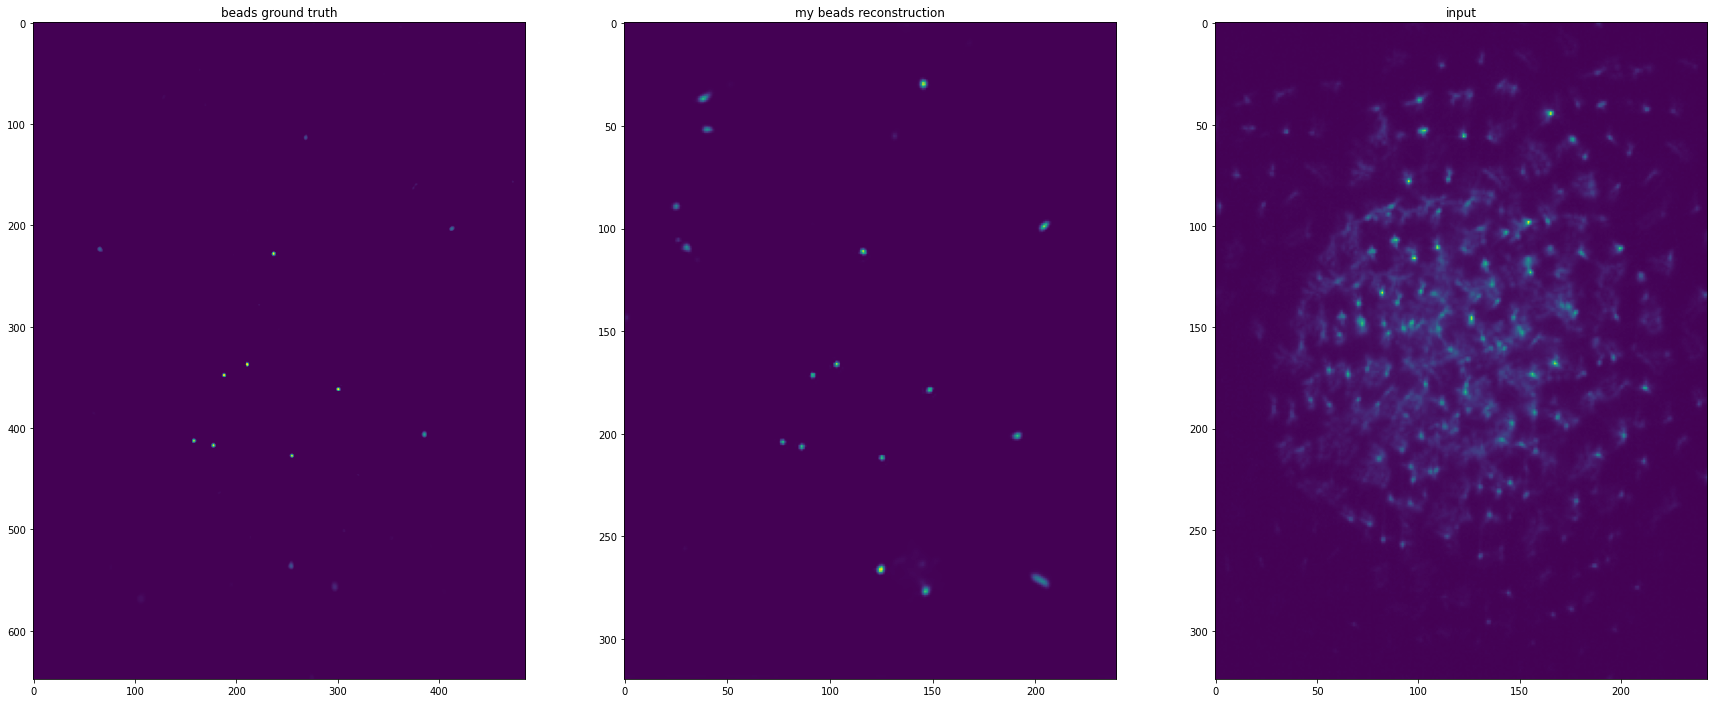

In [19]:
fig = plt.figure(figsize=(30, 30))
f0 = fig.add_subplot(1, 3, 1)
f0.set_title('beads ground truth')
f0.imshow(beads_gt)

f1 = fig.add_subplot(1, 3, 2)
f1.set_title('my beads reconstruction') # Normalized before simulation, but not after
f1.imshow(pred_beads)

f2 = fig.add_subplot(1, 3, 3)
f2.set_title('input')
f2.imshow(beads_input_normed)


plt.savefig(path.join(image_path, '{}_beads_reconstruction_{}.pdf'.format(model_description, epoch)))
plt.show()


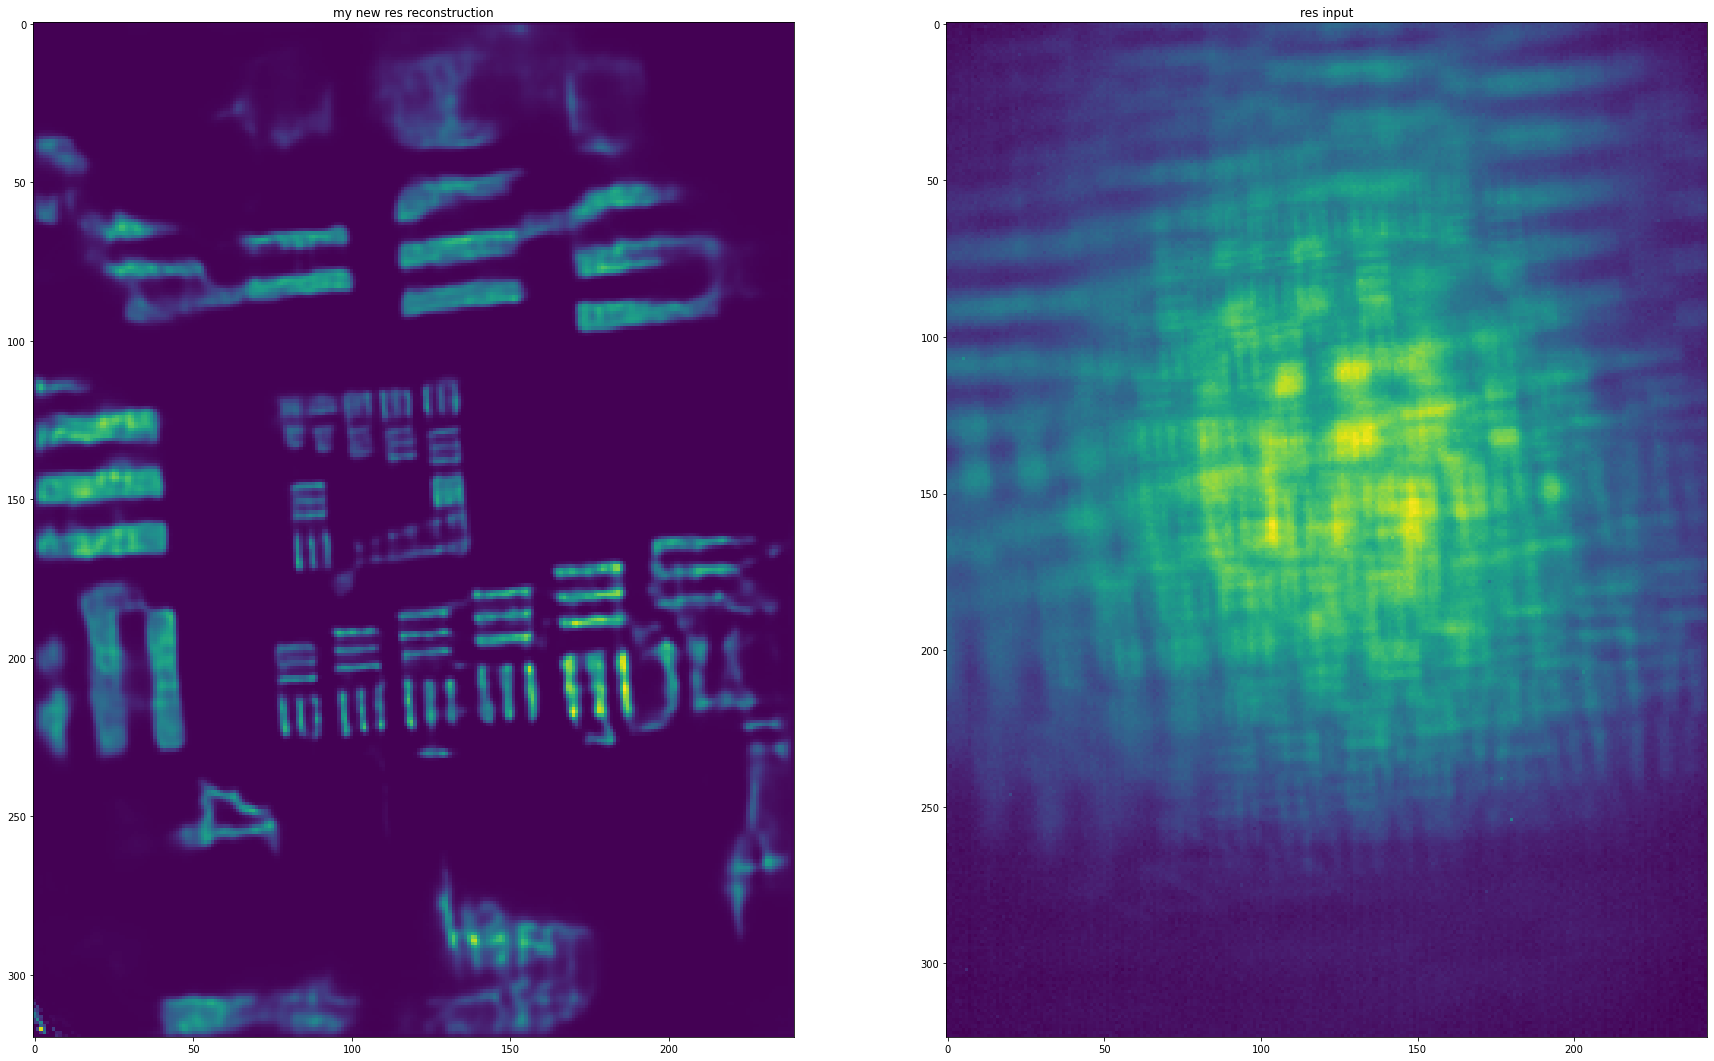

In [20]:
fig = plt.figure(figsize=(30, 30))


f1 = fig.add_subplot(1, 2, 1)
f1.set_title('my new res reconstruction') # Normalized before simulation, but not after
f1.imshow(pred_res_real)

f3 = fig.add_subplot(1, 2, 2)
f3.set_title('res input')
f3.imshow(real_res_normed)

plt.savefig(path.join(image_path, '{}_res_reconstruction_{}.pdf'.format(model_description, epoch)))

plt.show()

# With Wiener Deconvolution

In [21]:
# comps_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/comps.npy'
# weights_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/weights.npy'

In [22]:
# # Load in comps and weights
# h = np.load(comps_path)
# weights = np.load(weights_path)

In [23]:
# psf = tf.math.reduce_sum(h*weights, axis=0)
# psf = psf / tf.math.reduce_max(psf)
# K = 2000 #this variable can be learned, it has be greater than zero though


In [ ]:
# Niter = 20

# fm = ForwardModel()

# # res_wiener = normalize(fm.wiener_deconvolve(real_res_normed, weights, h, Niter))
# # beads_wiener = normalize(fm.wiener_deconvolve(beads_input_normed, weights, h, Niter))

# res_wiener = normalize(fm.wiener_deconvolve_one_step(real_res_normed, psf, K))
# beads_wiener = normalize(fm.wiener_deconvolve_one_step(beads_input_normed, psf, K))

In [ ]:
# beads_pred = model.predict(beads_wiener[None, ..., None]).squeeze()
# res_pred = model.predict(res_wiener[None, ..., None]).squeeze()

In [ ]:
# fig = plt.figure(figsize=(30, 30))

# f1 = fig.add_subplot(1, 3, 1)
# f1.set_title('my beads reconstruction') # Normalized before simulation, but not after
# f1.imshow(beads_pred)

# f2 = fig.add_subplot(1, 3, 2)
# f2.set_title('beads after wiener')
# f2.imshow(beads_wiener)

# f0 = fig.add_subplot(1, 3, 3)
# f0.set_title('beads ground truth')
# f0.imshow(beads_gt)

# plt.savefig(path.join(image_path, '{}_beads_reconstruction_{}.pdf'.format(model_description, epoch)))
# plt.show()


In [ ]:
# fig = plt.figure(figsize=(30, 30))


# f1 = fig.add_subplot(1, 3, 1)
# f1.set_title('my new res reconstruction') # Normalized before simulation, but not after
# f1.imshow(res_pred)

# f2 = fig.add_subplot(1, 3, 2)
# f2.set_title('res after wiener')
# f2.imshow(res_wiener)

# f3 = fig.add_subplot(1, 3, 3)
# f3.set_title('res input')
# f3.imshow(real_res_normed)



# plt.savefig(path.join(image_path, '{}_res_reconstruction_{}.pdf'.format(model_description, epoch)))

# plt.show()

In [ ]:
# print(normalize(fm.wiener_deconvolve(normalize(real_res.T), weights, h, Niter)))

In [ ]:
# print(normalize(fm.wiener_deconvolve(real_res.T, weights, h, Niter)))

In [ ]:
# x = normalize(fm.wiener_deconvolve(real_res.T, weights, h, Niter))
# z = normalize(fm.wiener_deconvolve(normalize(real_res.T), weights, h, Niter))

In [ ]:
# plt.imshow(x)

In [ ]:
# plt.imshow(z)

# Viewing learned PSF and K

In [20]:
comps_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/comps.npy'
weights_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/weights.npy'

# Load in comps and weights
h = np.load(comps_path)
weights = np.load(weights_path)

psf = tf.squeeze(tf.math.reduce_sum(h*weights, axis=0))
psf = psf / tf.math.reduce_max(psf)
K = 2000 #this variable can be learned, it has be greater than zero though

In [21]:
model.layers[0]

In [22]:
weights = model.layers[0].get_weights()

In [23]:
weights

[array([[[-1.7567787e-02,  3.3695459e-02,  2.2279011e-02, ...,
           4.1111387e-02, -3.2204553e-02,  3.7315920e-02],
         [-1.8136447e-02,  3.2279622e-02,  1.3400959e-02, ...,
           1.1426700e-02, -1.8102320e-02,  3.8884658e-02],
         [-2.9163722e-02,  6.7206700e-03,  1.9455176e-02, ...,
           4.1617792e-02, -1.0950785e-02,  2.2175947e-02],
         ...,
         [ 1.3663835e-02, -1.4453519e-03,  1.2776994e-02, ...,
          -1.8068116e-02,  4.3257996e-02,  2.6615292e-02],
         [ 2.9867729e-03, -1.0870983e-02, -1.8337736e-02, ...,
          -2.5812121e-02,  2.7603954e-02,  4.3071717e-02],
         [ 9.2180390e-03,  2.1910926e-03, -1.7215703e-02, ...,
          -2.4388965e-02,  2.6764287e-02,  3.8245719e-02]],
 
        [[-3.3202693e-02,  2.4194803e-02,  1.9962670e-02, ...,
           3.8144045e-02, -1.9352015e-02,  2.9490311e-02],
         [-2.6805770e-02,  2.0216046e-02,  1.8720619e-02, ...,
           2.6476379e-02, -1.2601564e-02,  2.9252162e-02],
       

In [24]:
learned_psf, k = weights
learned_psf

array([[[-1.7567787e-02,  3.3695459e-02,  2.2279011e-02, ...,
          4.1111387e-02, -3.2204553e-02,  3.7315920e-02],
        [-1.8136447e-02,  3.2279622e-02,  1.3400959e-02, ...,
          1.1426700e-02, -1.8102320e-02,  3.8884658e-02],
        [-2.9163722e-02,  6.7206700e-03,  1.9455176e-02, ...,
          4.1617792e-02, -1.0950785e-02,  2.2175947e-02],
        ...,
        [ 1.3663835e-02, -1.4453519e-03,  1.2776994e-02, ...,
         -1.8068116e-02,  4.3257996e-02,  2.6615292e-02],
        [ 2.9867729e-03, -1.0870983e-02, -1.8337736e-02, ...,
         -2.5812121e-02,  2.7603954e-02,  4.3071717e-02],
        [ 9.2180390e-03,  2.1910926e-03, -1.7215703e-02, ...,
         -2.4388965e-02,  2.6764287e-02,  3.8245719e-02]],

       [[-3.3202693e-02,  2.4194803e-02,  1.9962670e-02, ...,
          3.8144045e-02, -1.9352015e-02,  2.9490311e-02],
        [-2.6805770e-02,  2.0216046e-02,  1.8720619e-02, ...,
          2.6476379e-02, -1.2601564e-02,  2.9252162e-02],
        [-4.8875079e-02, 

In [25]:
k

array([[[0.687974  , 0.8531776 , 0.7487151 , 0.47681743, 0.8346978 ,
         0.55542946, 0.4232978 , 0.82356787, 0.43568   ]]], dtype=float32)

In [26]:
tf.math.reduce_sum(learned_psf)

<tf.Tensor: shape=(), dtype=float32, numpy=4189.2544>

In [27]:
tf.math.reduce_sum(psf)

<tf.Tensor: shape=(), dtype=float32, numpy=771.2059>

In [28]:

psf

<tf.Tensor: shape=(648, 486), dtype=float32, numpy=
array([[ 1.43681056e-04,  6.76471245e-05,  4.42230048e-05, ...,
        -5.52007928e-04, -4.90149774e-04,  7.18570955e-05],
       [ 1.79293769e-04,  1.33765323e-04,  5.59290289e-04, ...,
         2.75697355e-04,  3.07634878e-06, -2.64962378e-04],
       [ 7.86473684e-04,  8.26064497e-04, -6.05985231e-04, ...,
        -8.89535004e-05, -5.12485683e-04, -5.02176699e-05],
       ...,
       [ 5.09733218e-04,  3.24417597e-05, -2.50485667e-04, ...,
        -2.89694523e-04, -2.72260513e-04, -2.06281577e-04],
       [ 2.63469883e-05,  6.09428025e-05,  1.32647040e-06, ...,
         4.45763260e-04, -8.06662792e-05,  1.03453356e-04],
       [ 6.86824860e-05,  2.73233774e-04, -1.84922290e-04, ...,
         4.29617940e-04,  3.63872168e-05,  1.63478515e-04]], dtype=float32)>

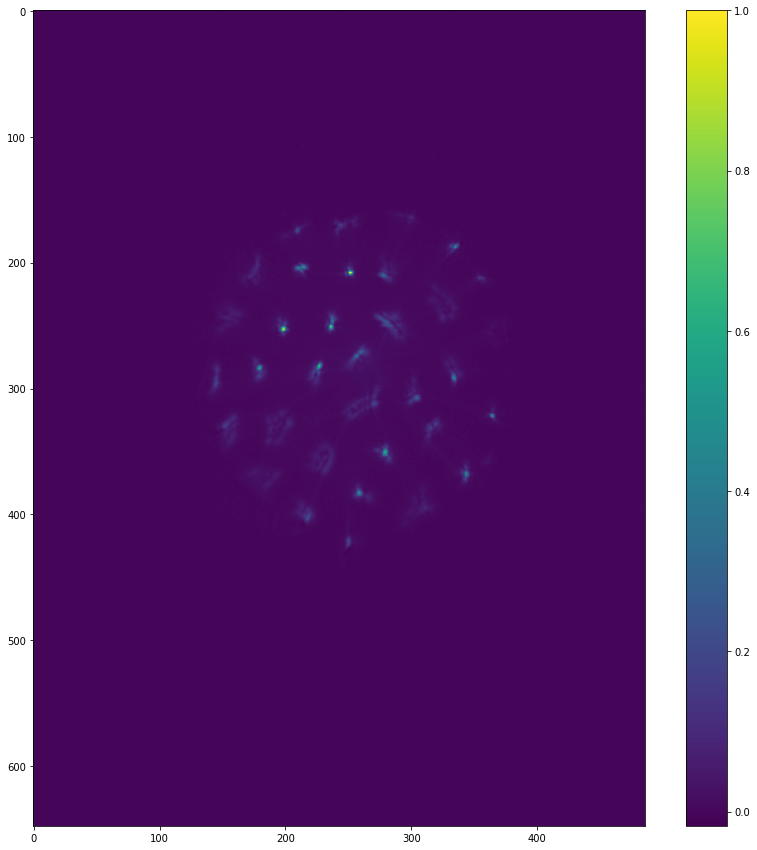

In [29]:
# Original PSf
plt.figure(figsize=(15,15))
plt.imshow(psf)
plt.colorbar()
plt.savefig(path.join(image_path, '{}_initial_psf_{}.pdf'.format(model_description, epoch)))

plt.show()


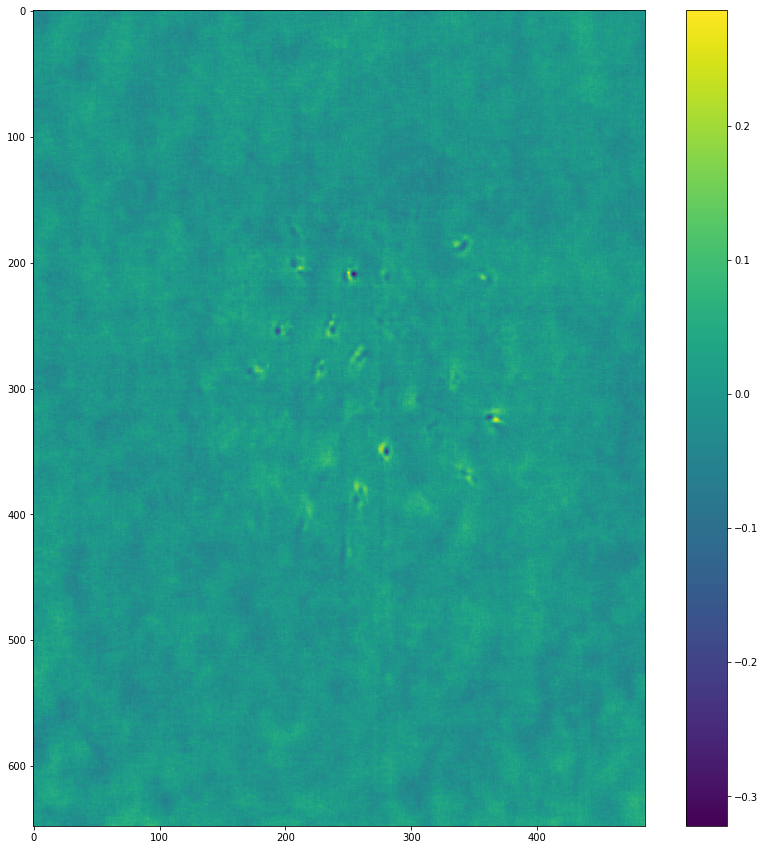

In [32]:
# Learned PSF
plt.figure(figsize=(15,15))
plt.imshow(learned_psf)
plt.colorbar()
plt.savefig(path.join(image_path, '{}_learned_psf_{}.pdf'.format(model_description, epoch)))
plt.show()


In [ ]:
# Setting model weights to original
# model.layers[0].set_weights([psf, tf.constant(K)])